In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

%matplotlib widget 

Environment closely follows OpenAI gym API. Currently can not be invoked with ```gym.make("env_id")```, though it should be easy to do.

In [2]:
import env
checkers_env = env.Env()

In [3]:
""" Various plotting helper methods """

def show_state(state):
    plt.imshow(state)
    plt.show()

def show_board(board):
   cmap = colors.ListedColormap(['white', 'red'])
   bounds=[0,0.5,18]
   norm = colors.BoundaryNorm(bounds, cmap.N)
   # plt.figure(figsize=(4,4))
   plt.imshow(board, cmap=cmap, norm=norm, interpolation='none')
   plt.xticks(np.arange(0.5,8.5), [])
   plt.yticks(np.arange(0.5,8.5), [])

   plt.grid()

def do_the_flip(arr):
    return np.flip(np.flip(np.flip(arr, 0), 0), 1)

def show_trajectory_item(trajectory, index):
    board_i = monte_carlo_tree.state_to_board(trajectory[index].original_state)
    show_board(do_the_flip(board_i[0] + board_i[1]))

## Random Play Tree

This is very basic algorithm that plays the game by making random moves. Sometimes it reaches the end goal, but overall it supper inneficient.

In [4]:
import monte_carlo_tree


def random_play():
    '''
    Play a game using random tree strategy
    '''
        
    tree = monte_carlo_tree.RandomPlayTree(checkers_env, 8)
    
    root_node = tree.root_node
    return tree.simulate(root_node)
    

def build_stats(playfunc, n_games=100):
    '''
    Play a number of random games and display result
    '''

    black_wins = 0
    white_wins = 0
    draws = 0
    moves = []
    
    for _ in range(n_games):
        m = playfunc()
        if m.reward > 0:
            black_wins += 1
        elif m.reward < 0:
            white_wins += 1
        elif m.reward == 0:
            draws += 1
       
        moves.append(m.depth())
    
    print("Blacks: ", black_wins, "Whites: ", white_wins, "Draws: ", draws, "Moves mean:", np.mean(moves))

In [5]:
# build_stats(random_play, 10)

## Monte Carlo Search Tree

In [6]:
from monte_carlo_tree import MonteCarloPlayTree


def mtsc_play():
    '''
    Play a game using MonteCarloSearchTree
    '''

    mcst = MonteCarloPlayTree(checkers_env, 8)
    
    root_node = mcst.root_node
    terminal_node = mcst.simulate(root_node)
    
    return terminal_node


In [7]:
# build_stats(mtsc_play, 10)

## Guided Tree Search

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BOARD_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):

    def __init__(self, board_size):
        super(ActorCritic, self).__init__()
        
        self.board_size = BOARD_SIZE

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Policy head
        self.act_conv1 = nn.Conv2d(128, 4, kernel_size=1)
        self.act_fc1 = nn.Linear(4*(self.board_size**2), self.board_size**4)
        
        # Critic head
        self.val_conv1 = nn.Conv2d(128, 2, kernel_size=1)
        self.val_fc1 = nn.Linear(2*self.board_size**2, 64)
        self.val_fc2 = nn.Linear(64, 1)

        # Activation Functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        
    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        # Actor head
        y_actions = self.relu(self.act_conv1(x)).view(-1, 4*self.board_size**2)
        y_actions = self.act_fc1(y_actions)
        y_actions = self.sigmoid(y_actions)
        
        # Critic head
        y_value = self.relu(self.val_conv1(x))
        y_value = y_value.view(-1, 2*(self.board_size**2))
        y_value = self.relu(self.val_fc1(y_value))
        y_value = self.tanh(self.val_fc2(y_value))

        return y_actions, y_value

actor_critic_network = ActorCritic(BOARD_SIZE).to(device)

In [9]:
tree = monte_carlo_tree.GuidedMonteCarloPlayTree(checkers_env, BOARD_SIZE, actor_critic_network, device)

In [10]:
losses = []

In [11]:
# tree eats too much memory. free up every 10 cycles

for i in range(20):
    tree = monte_carlo_tree.GuidedMonteCarloPlayTree(checkers_env, BOARD_SIZE, actor_critic_network, device)
    for loss in tree.train(10):
        losses.append(loss)
    torch.save(actor_critic_network.state_dict(), "./actor_critic.pt")
    del tree.root_node

Iteration # 0
number of actions:  53
Loss: tensor(143.9851, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 1
number of actions:  46
Loss: tensor(100.6600, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 2
number of actions:  48
Loss: tensor(111.1032, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 3
number of actions:  50
Loss: tensor(129.3570, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 4
number of actions:  47
Loss: tensor(103.3329, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 5
number of actions:  47
Loss: tensor(109.8074, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 6
number of actions:  57
Loss: tensor(199.1357, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 7
number of actions:  52
Loss: tensor(142.8255, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 8
number of actions:  54
Loss: tensor(164.8351, device='cuda:0', grad_fn=<SumBackward0>)
Iteration # 9
number of actions:  51
Loss: tensor(140.5169, device='cuda:0', grad_fn=<SumBa

In [12]:
def gmcts_play():
    '''
    Play a game using random tree strategy
    '''
        
    tree = monte_carlo_tree.GuidedMonteCarloPlayTree(checkers_env, BOARD_SIZE, actor_critic_network, device)
    
    root_node = tree.root_node
    return tree.simulate(root_node)

In [13]:
build_stats(gmcts_play, 100)

Blacks:  3 Whites:  2 Draws:  95 Moves mean: 51.62


In [14]:
example = torch.rand(1, 8, 8).to(device)
traced_script_module = torch.jit.trace(actor_critic_network, example)
traced_script_module.save("model.pt")

In [23]:
class Actor(nn.Module):

    def __init__(self, actor_critic_network):
        super(Actor, self).__init__()
        self.actor_critic = actor_critic_network

    def forward(self, x):
        y, _ = self.actor_critic(x)
        return y

class Critic(nn.Module):

    def __init__(self, actor_critic_network):
        super(Actor, self).__init__()
        self.actor_critic = actor_critic_network

    def forward(self, x):
        _, y = self.actor_critic(x)
        return y

actor_network = Actor(actor_critic_network).to(torch.device("cpu"))
critic_network = Actor(actor_critic_network).to(torch.device("cpu"))

In [24]:
from torch import jit

example = torch.rand(1, 8, 8).to(torch.device("cpu"))
print(example.size())
traced_script_module = torch.jit.trace(actor_network, example)
traced_script_module.save("actor_network.pt")

torch.Size([1, 8, 8])


In [25]:
actor_network(example)

tensor([[7.9339e-05, 9.3436e-01, 9.9778e-01,  ..., 5.1890e-02, 6.6072e-06,
         9.9996e-01]], grad_fn=<SigmoidBackward0>)

In [18]:
from matplotlib import pyplot as plt 

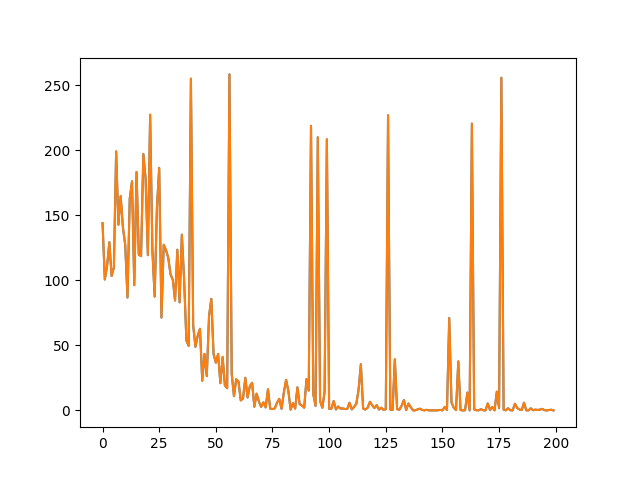

In [22]:
plt.plot([l.detach().cpu().numpy() for l in losses])
plt.show()